In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
IS_COLAB = 1
MODEL_NAME = 'modelfull_24_6_classes'

In [3]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/ecgtrain/downsample_custom_cut_24_6_classes_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: downsample_24_train_data/PAB/217-9257.png  
  inflating: downsample_24_train_data/PAB/217-173.png  
  inflating: downsample_24_train_data/PAB/107-44734.png  
  inflating: downsample_24_train_data/PAB/217-6651.png  
  inflating: downsample_24_train_data/PAB/107-50596.png  
  inflating: downsample_24_train_data/PAB/217-54336.png  
  inflating: downsample_24_train_data/PAB/217-3710.png  
  inflating: downsample_24_train_data/PAB/107-7130.png  
  inflating: downsample_24_train_data/PAB/107-14631.png  
  inflating: downsample_24_train_data/PAB/217-17684.png  
  inflating: downsample_24_train_data/PAB/107-54849.png  
  inflating: downsample_24_train_data/PAB/107-48929.png  
  inflating: downsample_24_train_data/PAB/217-6709.png  
  inflating: downsample_24_train_data/PAB/107-35375.png  
  inflating: downsample_24_train_data/PAB/217-5704.png  
  inflating: downsample_24_train_data/PAB/107-61190.png  
  inflating: downsample_24_tr

In [5]:
# Load data from CSV files
train_data = pd.read_csv("newtrain.csv")
val_data = pd.read_csv("newval.csv")
test_data = pd.read_csv("newtest.csv")

In [6]:
test_data['label'].value_counts()

N      2194
L       551
R       499
PAB     405
A        61
V        52
Name: label, dtype: int64

In [7]:
label_mapping = {'N': 0, 'V': 1, 'PAB': 2, 'R': 3, 'L': 4, 'A': 5}
train_data = train_data.replace({'label': label_mapping})
val_data = val_data.replace({'label': label_mapping})
test_data = test_data.replace({'label': label_mapping})

# EDA

In [8]:
# plot number of unique value in label column of newtrain.csv
train_data['label'].value_counts()

0    30000
1     4910
4     4184
3     3817
2     2712
5     1519
Name: label, dtype: int64

In [9]:
val_data['label'].value_counts()

0    10000
1     1637
4     1395
3     1272
2      904
5      506
Name: label, dtype: int64

In [10]:
test_data['label'].value_counts()


0    2194
4     551
3     499
2     405
5      61
1      52
Name: label, dtype: int64

In [11]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, df, num_classes, shuffle=False, batch_size = 10):
        self.indices = None
        self.length = None
        self.df: pd.DataFrame = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.__len__()
        self.on_epoch_end()

    def __len__(self):
        self.length = len(self.df) // self.batch_size
        if len(self.df) % self.batch_size != 0:
            self.length +=1
        return self.length

    def __getitem__(self, idx):
        X = []
        y = []
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        if idx == self.length-1:
            indices = self.indices[idx*self.batch_size:]
        for i, data_index in enumerate(indices):
            img_path = self.df.loc[data_index, 'path']
            img = load_img(img_path, color_mode="grayscale", target_size=(128, 128))
            img = img_to_array(img) / 255.0
            label = to_categorical(self.df.loc[data_index, 'label'], self.num_classes)

            X.append(img)
            y.append(label)
        X = np.stack(X)
        y = np.stack(y)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [13]:
BATCH_SIZE = 256 if IS_COLAB else 10

In [14]:
train_gen = DataGenerator(df=train_data, batch_size=BATCH_SIZE, shuffle=True, num_classes=6)
val_gen = DataGenerator(df=val_data, batch_size=BATCH_SIZE, shuffle=False, num_classes=6)
test_gen = DataGenerator(df=test_data, batch_size=BATCH_SIZE, shuffle=False, num_classes=6)

In [15]:

# Define CNN model
model = keras.Sequential(
    [
        layers.Conv2D(64, (3, 3), activation="elu",
                      input_shape=(128, 128, 1), padding="same", kernel_initializer='glorot_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding="same", activation="elu", kernel_initializer='glorot_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=2, ), 
        layers.Conv2D(128, (3, 3), padding="same", activation="elu", kernel_initializer='glorot_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding="same", activation="elu", kernel_initializer='glorot_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=2, ),
        layers.Conv2D(256, (3, 3), padding="same", activation="elu", kernel_initializer='glorot_normal'),
        layers.BatchNormalization(), 
        layers.Conv2D(256, (3, 3), padding="same", activation="elu", kernel_initializer='glorot_normal'),
        layers.BatchNormalization(), 
        layers.MaxPooling2D((2, 2), strides=2, ),
        layers.Flatten(),
        layers.Dense(2048, activation="elu", kernel_initializer='glorot_normal'),
        layers.BatchNormalization(), 
        layers.Dropout(.5),
        layers.Dense(6, kernel_initializer='glorot_normal'),
    ]
)


In [16]:

# Compile model
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                        

In [ ]:
# Train model
CP_PATH = f'/content/drive/MyDrive/ecgtrain/{MODEL_NAME}' if IS_COLAB else 'tensorflow'
# model = tf.keras.models.load_model(CP_PATH)
checkpoint = tf.keras.callbacks.ModelCheckpoint(CP_PATH, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
cb_l = [checkpoint]
history = model.fit(
    train_gen, validation_data=val_gen, epochs=20, callbacks=cb_l
)

Epoch 1/20
185/185 [==============================] - ETA: 0s - loss: 7.2168 - accuracy: 0.2566
Epoch 1: accuracy improved from -inf to 0.25663, saving model to /content/drive/MyDrive/ecgtrain/modelfull_24_6_classes


185/185 [==============================] - 247s 1s/step - loss: 7.2168 - accuracy: 0.2566 - val_loss: 11.9085 - val_accuracy: 0.3361
Epoch 2/20
185/185 [==============================] - ETA: 0s - loss: 7.2213 - accuracy: 0.2792
Epoch 2: accuracy improved from 0.25663 to 0.27916, saving model to /content/drive/MyDrive/ecgtrain/modelfull_24_6_classes


185/185 [==============================] - 207s 1s/step - loss: 7.2213 - accuracy: 0.2792 - val_loss: 11.7990 - val_accuracy: 0.0797
Epoch 3/20
185/185 [==============================] - ETA: 0s - loss: 8.3243 - accuracy: 0.2372
Epoch 3: accuracy did not improve from 0.27916
185/185 [==============================] - 194s 1s/step - loss: 8.3243 - accuracy: 0.2372 - val_loss: 6.4384 - val_accuracy: 0.2264
Epoch 4/20
 56/185 [========>.....................] - ETA: 2:02 - loss: 8.3588 - accuracy: 0.2620

In [ ]:
import json
import os
ECG_PATH = '/content/drive/MyDrive/ecgtrain/'


In [ ]:
# save history
hist_dict = history.history
json.dump(hist_dict, open(os.path.join(ECG_PATH, MODEL_NAME, 'hist.json'), 'w'))

In [ ]:
model.save(os.path.join(ECG_PATH, MODEL_NAME, f'{MODEL_NAME}.h5'))

In [ ]:
model = tf.keras.models.load_model(os.path.join(ECG_PATH, MODEL_NAME, f'{MODEL_NAME}.h5'))

In [ ]:
# load history
hist = json.load(open(os.path.join(ECG_PATH, MODEL_NAME, 'hist.json'), 'r'))

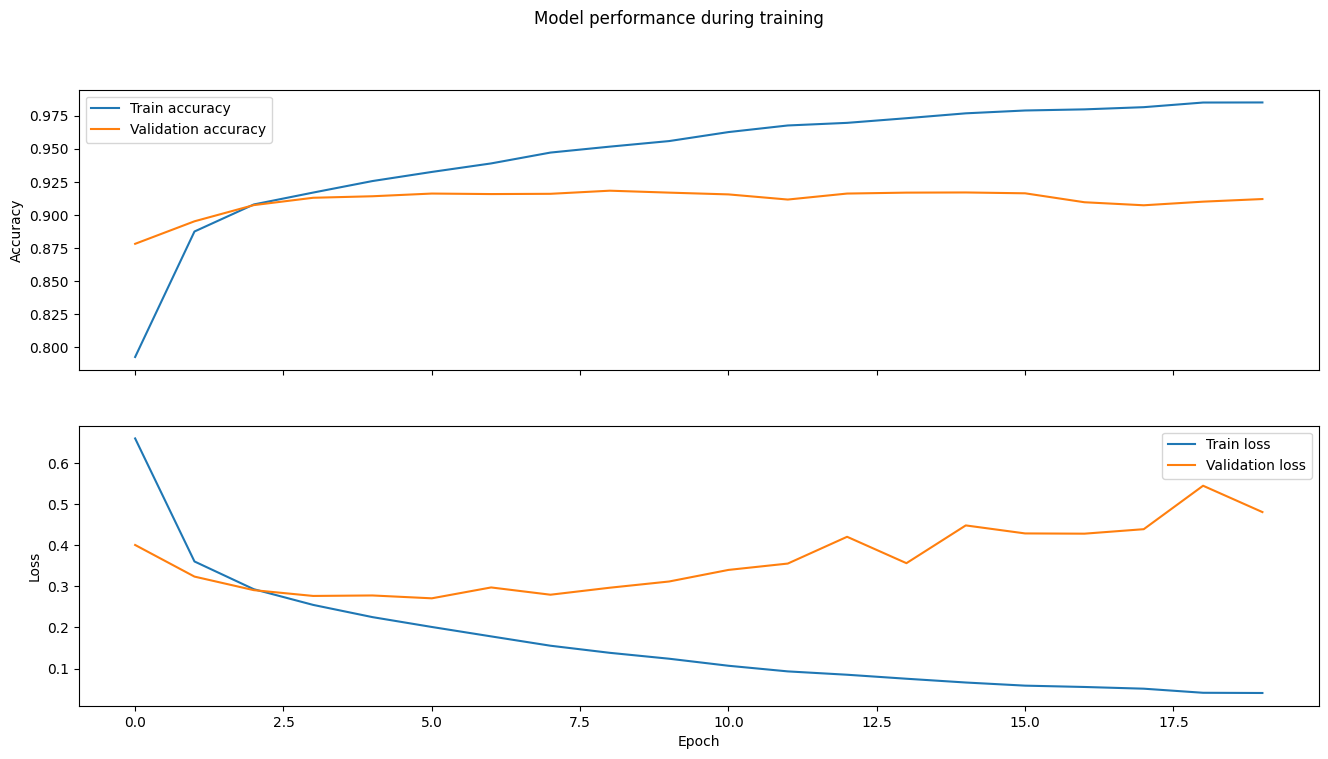

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
axes[0].plot(hist['accuracy'])
axes[0].plot(hist['val_accuracy'])
axes[0].set_ylabel('Accuracy')
axes[1].plot(hist['loss'])
axes[1].plot(hist['val_loss'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
fig.suptitle('Model performance during training')
axes[0].legend(('Train accuracy', 'Validation accuracy'))
axes[1].legend(('Train loss', 'Validation loss'))

In [ ]:
test_labels = to_categorical(test_data["label"], num_classes=6)

In [ ]:
test_loss, test_acc = model.evaluate(test_gen, verbose=2)

15/15 - 10s - loss: 3.0605 - accuracy: 0.6446 - 10s/epoch - 679ms/step


In [ ]:
label_mapping = {'N': 0, 'V': 1, 'PAB': 2, 'R': 3, 'L': 4, 'A': 5}

15/15 - 2s - loss: 3.0605 - accuracy: 0.6446 - 2s/epoch - 143ms/step
Test accuracy: 0.6446039080619812
Test loss: 3.060486078262329
15/15 [==============================] - 3s 203ms/step
[[1939  168    0   52   17   18]
 [  21   22    0    0    1    8]
 [   1   11  393    0    0    0]
 [ 422   50    0   15    0   12]
 [  54  295  146    1   54    1]
 [  51    6    1    1    0    2]]


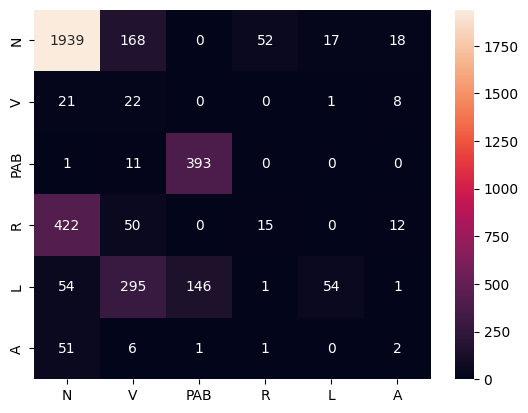

In [ ]:
# test model
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)
sns.heatmap(cm, annot=True, xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), fmt="d")
plt.show()



In [ ]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.84      0.39       103
           1       0.28      0.85      0.42        13
           2       0.50      1.00      0.67         1
           3       0.74      0.05      0.09       294
           4       1.00      0.08      0.14        13
           5       0.00      0.00      0.00         1

    accuracy                           0.27       425
   macro avg       0.46      0.47      0.28       425
weighted avg       0.61      0.27      0.18       425



In [ ]:
# print precision, recall, f1-score
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred, average='macro')


(0.46103801169590647, 0.4692260274784546, 0.28418104235184866, None)

In [ ]:
# # load all image from output folder and predict
# import os
# from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.models import load_model
# import numpy as np
# import pandas as pd

# # load model
# model = load_model('model2.h5')

# # load all images in a directory
# loaded_images = list()
# for filename in os.listdir('output'):
#     # load image
#     img = load_img('output/' + filename, color_mode="grayscale", target_size=(128, 128))
#     # convert to array
#     img = img_to_array(img)
#     # scale pixel values to [0, 1]
#     img = img.astype('float32')
#     img = img / 255.0
#     # store
#     loaded_images.append(img)
    
# # create a numpy array
# loaded_images = np.asarray(loaded_images)

# # predict
# yhat = model.predict(loaded_images)



# print(yhat)


In [ ]:
# # convert to labels
# labels = np.argmax(yhat, axis=1)
# # print labels
# print(labels)

# # print frequency of each label in separated lines
# arr_rs = np.unique(labels, return_counts=True)
# print('---------------------------------')
# for i in range(len(arr_rs[0])):
#     print(arr_rs[0][i], " - ", arr_rs[1][i])
